In [15]:
# Logistic regression for classifying two classes (zero and one) from MNIST. 
# Not using any routines from PyTorch other than the ones that help download the data. 
# Using Numpy to code up the optimization algorithm

import numpy as np
import matplotlib.pyplot as plt
from numpy.ma.core import shape
from tqdm import tqdm

(a)

In [16]:
# Dataset preparation
# Select all the samples belonging to the first two classes from MNIST’s training dataset as our training dataset. 
# Also create a validation dataset for the two classes by picking samples corresponding to the first two classes from the validation set of the MNIST dataset. 
# You can subsample input images from 28×28 to 14×14 if needed.

import torchvision
import torchvision.transforms as transforms

# Download the MNIST dataset (skip if already exists)
train_dataset = torchvision.datasets.MNIST(root='./data', train=True, transform=transforms.ToTensor(), download=True)
test_dataset = torchvision.datasets.MNIST(root='./data', train=False, transform=transforms.ToTensor(), download=True)

# Select the first two classes
train_idx = (train_dataset.targets == 0) | (train_dataset.targets == 1)
train_dataset.targets = train_dataset.targets[train_idx]
train_dataset.data = train_dataset.data[train_idx]

test_idx = (test_dataset.targets == 0) | (test_dataset.targets == 1)
test_dataset.targets = test_dataset.targets[test_idx]
test_dataset.data = test_dataset.data[test_idx]

# Subsample and normalize
train_dataset.data = train_dataset.data[:, ::2, ::2]
test_dataset.data = test_dataset.data[:, ::2, ::2]
train_dataset.data = train_dataset.data.float()/255
test_dataset.data = test_dataset.data.float()/255

print(train_dataset.data.shape)
print(test_dataset.data.shape)

torch.Size([12665, 14, 14])
torch.Size([2115, 14, 14])


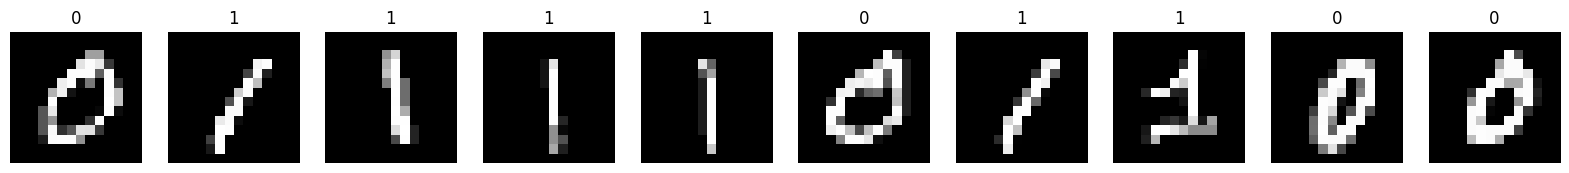

In [17]:
# Visualize the first 10 samples with labels from the training dataset
fig, axs = plt.subplots(1, 10, figsize=(20, 2))
for i in range(10):
    axs[i].imshow(train_dataset.data[i], cmap='gray')
    axs[i].set_title(train_dataset.targets[i].item())
    axs[i].axis('off')
plt.show()


In [18]:
# Convert data to numpy arrays and flatten images
X_train = train_dataset.data.reshape(-1, 196).numpy()  # 14x14 = 196 features
y_train = train_dataset.targets.numpy()
X_test = test_dataset.data.reshape(-1, 196).numpy()
y_test = test_dataset.targets.numpy()

# Convert labels 0, 1 to 1, -1
y_train = np.where(y_train == 0, 1, -1)
y_test = np.where(y_test == 0, 1, -1)

# Print the shapes of the data
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)


(12665, 196) (12665,)
(2115, 196) (2115,)


(b) Logistic regression

$$\underset{w\in\mathbb{R}^d,w_0\in\mathbb{R}}{\operatorname*{argmin}} \frac 1n \sum_{i=1}^n \log \left( 1+e^{-y_i} ( w^\top x_i+w_0 )  \right) + \frac \lambda 2 \left( \left\| w \right\|_2^2 + w_0^2 \right)$$

where:
* $x_i\in\mathbb{R}^{196}$ is the $i$-th sample, 
* $y_i\in\{-1,1\}$ is the label of the $i$-th sample (1 for digit "0", -1 for digit "1"), 
* $\lambda>0$ is the regularization parameter.

In [19]:
class LogisticRegression:
    def __init__(self, w, w0, lambda_reg) :
        self.w = w  # (196,)
        self.w0 = w0  # scalar
        self.dw = np.zeros(self.w.shape)  # (196,)
        self.dw0 = 0.0  # scalar
        self.lambda_reg = lambda_reg  # scalar
        
        self.X = None  # (n, 196)
        self.y = None  # (n,)
        self.z = None  # (n,)

    def forward(self, X, y):
        self.z = X @ self.w + self.w0  # (n,)
        self.X = X  # (n, 196)
        self.y = y  # (n,)
        
        loss = np.mean(np.log(1 + np.exp(-y * self.z))) + self.lambda_reg / 2 * (np.sum(self.w**2) + self.w0**2)  # scalar
        
        # Also calculate the prediction error
        y_hat = np.sign(self.z)  # (n,)
        pred_error = np.mean(y_hat != y)  # scalar
        return loss, pred_error

    def backward(self):
        exp_term = np.exp(-self.y * self.z)  # (n,)
        factor = exp_term / (1 + exp_term)  # (n,)
        error = -self.y * factor  # (n,)
        self.dw = 1 / self.y.shape[0] * (self.X.T @ error) + self.lambda_reg * self.w  # (196,)
        self.dw0 = 1 / self.y.shape[0] * np.sum(error) + self.lambda_reg * self.w0  # scalar
        
    def step(self, learning_rate):
        self.w = self.w - learning_rate * self.dw  # (196,)
        self.w0 = self.w0 - learning_rate * self.dw0  # scalar

    def zero_grad(self):
        self.dw, self.dw0 = 0 * self.dw, 0 * self.dw0


In [20]:
# Initialize parameters
n_features = X_train.shape[1]
w = np.random.randn(n_features) * 0.01
w0 = np.random.randn() * 0.01
lambda_reg = 0.01
learning_rate = 1e-3
n_iterations = 100

# Store initial weights for later
w_init = w.copy()
w0_init = w0

model = LogisticRegression(w, w0, lambda_reg)

losses = []
errors = []
# Training loop
for i in tqdm(range(n_iterations)):
    loss, error = model.forward(X_train, y_train)
    losses.append(loss)
    errors.append(error)
    model.backward()
    model.step(learning_rate)
    model.zero_grad()

# Calculate final validation loss
val_loss, val_error = model.forward(X_test, y_test)

# Print final loss and error
print(f"Final training loss: {losses[-1]:.4f}")
print(f"Final training error: {errors[-1]:.4f}")
print(f"Final validation loss: {val_loss:.4f}")
print(f"Final validation error: {val_error:.4f}")
    

100%|██████████| 100/100 [00:01<00:00, 65.76it/s]

Final training loss: 0.6236
Final training error: 0.0508
Final validation loss: 0.6216
Final validation error: 0.0487


Slope of the line: -0.00112


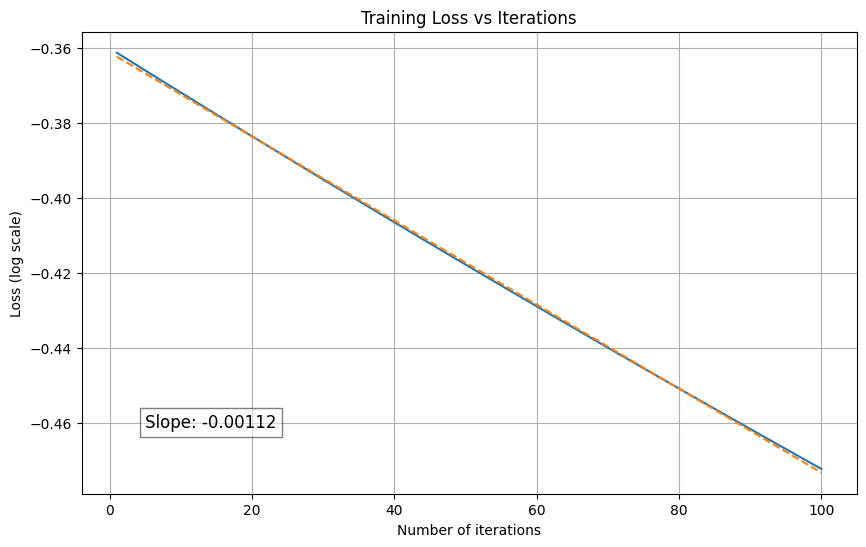

In [21]:
# Plot loss on semi-log scale
iterations = np.arange(1, n_iterations + 1)
log_losses = np.log(losses)
plt.figure(figsize=(10, 6))
plt.plot(iterations, log_losses, label='Log Loss')

# Calculate slope of the line, and add it to the plot
slope, intercept = np.polyfit(iterations, log_losses, 1)
print(f"Slope of the line: {slope:.4g}")
fitted_line = intercept + slope * iterations
plt.plot(iterations, fitted_line, label=f'Fitted line (slope: {slope:.4g})', linestyle='--')
plt.text(0.05 * n_iterations, np.min(log_losses) + 0.1 * (np.max(log_losses) - np.min(log_losses)),
         f'Slope: {slope:.4g}', fontsize=12, bbox=dict(facecolor='white', alpha=0.5))

plt.xlabel('Number of iterations')
plt.ylabel('Loss (log scale)')
plt.title('Training Loss vs Iterations')
plt.grid(True)
plt.show()


(c) Answered in LaTex
(d)

In [22]:
# Optimize the objective in Eq. (1) again, this time using gradient descent with Nesterov’s acceleration.
# Implement the Nesterov’s accelerated gradient descent algorithm to optimize the objective in Eq. (1).
# Use the same hyperparameters as in the previous part.

class NesterovLogisticRegression:
    def __init__(self, w, w0, lambda_reg, momentum):
        self.w = w  # (196,)
        self.w0 = w0  # scalar
        self.dw = np.zeros(self.w.shape)  # (196,)
        self.dw0 = 0.0  # scalar
        self.vw = np.zeros(self.w.shape)  # (196,)
        self.vw0 = 0.0  # scalar
        self.lambda_reg = lambda_reg  # scalar
        self.momentum = momentum
        
        self.X = None  # (n, 196)
        self.y = None  # (n,)
        self.z = None  # (n,)

    def forward(self, X, y):
        self.z = X @ self.w + self.w0  # (n,)
        self.X = X  # (n, 196)
        self.y = y  # (n,)
        
        loss = (
            np.mean(np.log(1 + np.exp(-y * self.z))) + 
            self.lambda_reg / 2 * (np.sum(self.w**2) + self.w0**2)
        )  # scalar
        
        # Also calculate the prediction error
        y_hat = np.sign(self.z)  # (n,)
        pred_error = np.mean(y_hat != y)  # scalar
        return loss, pred_error

    def backward(self):
        exp_term = np.exp(-self.y * self.z)  # (n,)
        factor = exp_term / (1 + exp_term)  # (n,)
        error = -self.y * factor  # (n,)
        self.dw = 1 / self.y.shape[0] * (self.X.T @ error) + self.lambda_reg * self.w  # (196,)
        self.dw0 = 1 / self.y.shape[0] * np.sum(error) + self.lambda_reg * self.w0  # scalar
        
    def step(self, learning_rate):
        # Nesterov update
        w_prev = self.w.copy()
        w0_prev = self.w0
        
        self.vw = self.momentum * self.vw - learning_rate * self.dw
        self.vw0 = self.momentum * self.vw0 - learning_rate * self.dw0
        
        self.w = w_prev + self.vw
        self.w0 = w0_prev + self.vw0

    def zero_grad(self):
        self.dw, self.dw0 = 0 * self.dw, 0 * self.dw0



Using L = 0.75
Momentum coefficient: 0.9665


100%|██████████| 100/100 [00:01<00:00, 65.81it/s]


Final training loss (Nesterov): 0.1557
Final training error (Nesterov): 0.0044
Final validation loss (Nesterov): 0.1468
Final validation error (Nesterov): 0.0019
Slope of the line (Nesterov): -0.01684


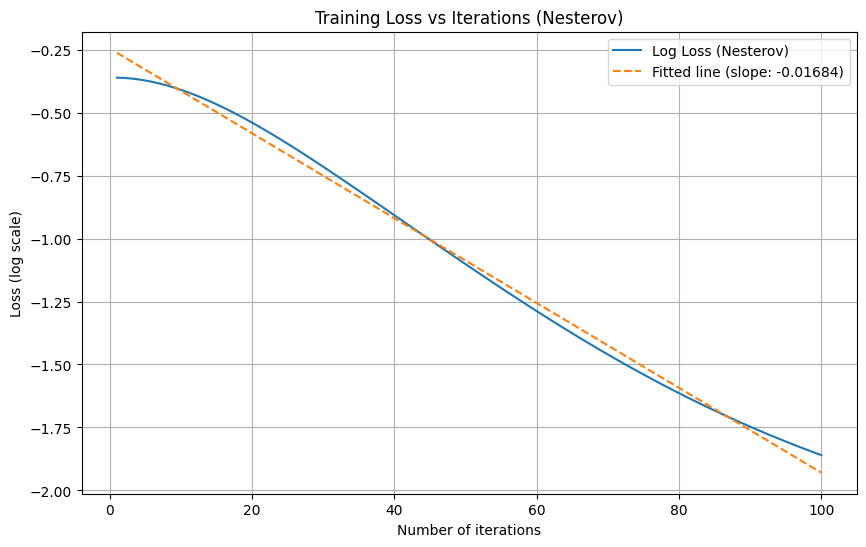


Using L = 0.8
Momentum coefficient: 0.9665


100%|██████████| 100/100 [00:01<00:00, 66.98it/s]


Final training loss (Nesterov): 0.1557
Final training error (Nesterov): 0.0044
Final validation loss (Nesterov): 0.1468
Final validation error (Nesterov): 0.0019
Slope of the line (Nesterov): -0.01684


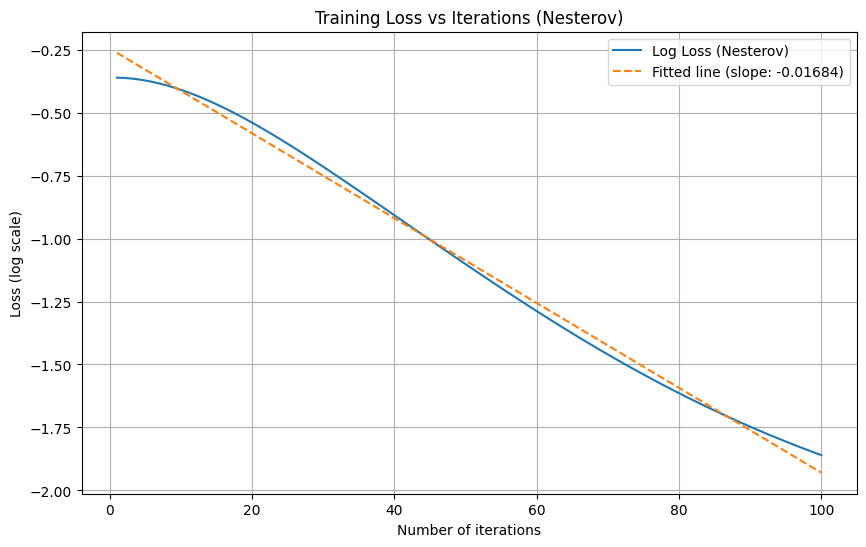


Using L = 0.85
Momentum coefficient: 0.9665


100%|██████████| 100/100 [00:01<00:00, 66.75it/s]


Final training loss (Nesterov): 0.1557
Final training error (Nesterov): 0.0044
Final validation loss (Nesterov): 0.1468
Final validation error (Nesterov): 0.0019
Slope of the line (Nesterov): -0.01684


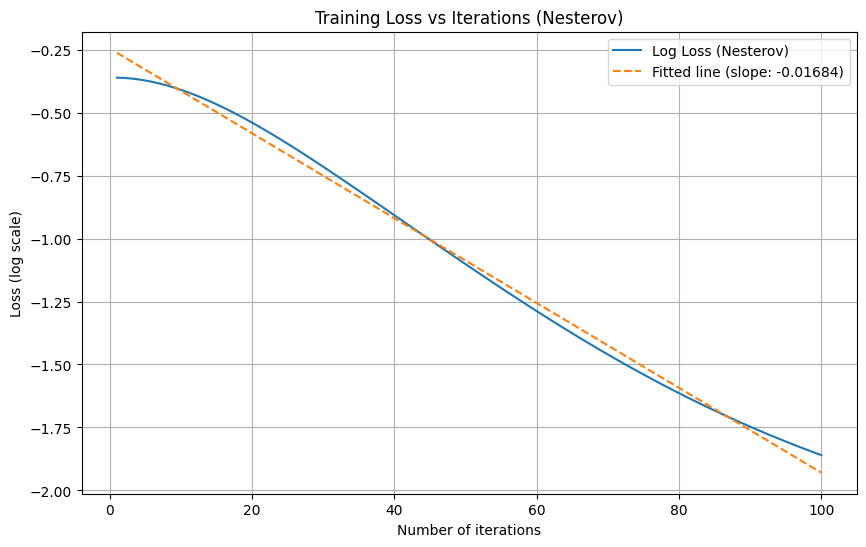


Using L = 0.9
Momentum coefficient: 0.9665


100%|██████████| 100/100 [00:01<00:00, 65.23it/s]


Final training loss (Nesterov): 0.1557
Final training error (Nesterov): 0.0044
Final validation loss (Nesterov): 0.1468
Final validation error (Nesterov): 0.0019
Slope of the line (Nesterov): -0.01684


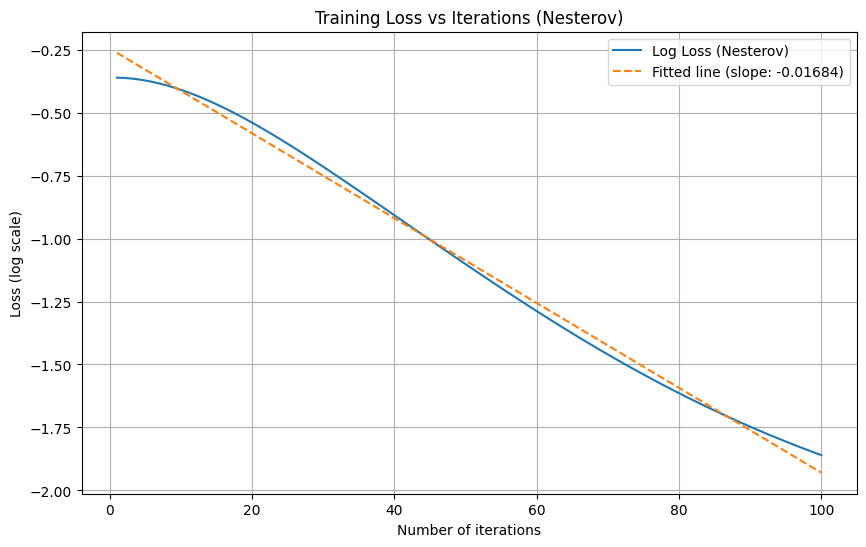


Using L = 0.95
Momentum coefficient: 0.9665


100%|██████████| 100/100 [00:01<00:00, 54.76it/s]


Final training loss (Nesterov): 0.1557
Final training error (Nesterov): 0.0044
Final validation loss (Nesterov): 0.1468
Final validation error (Nesterov): 0.0019
Slope of the line (Nesterov): -0.01684


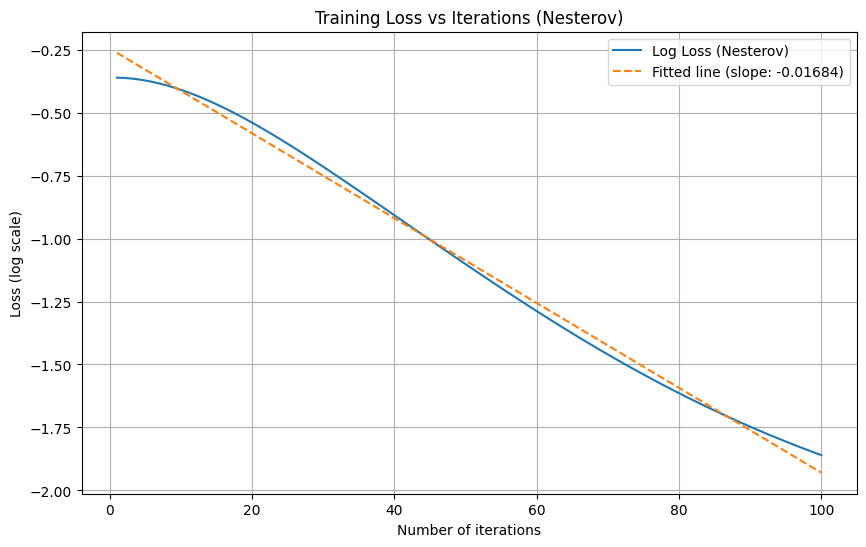

In [23]:
# Initialize parameters (using the same initial weights as before)
w = w_init.copy()
w0 = w0_init
lambda_reg = 0.01
learning_rate = 1e-3
n_iterations = 100

# Using the slope from (b)
m = abs(slope)
Ls = [0.75, 0.80, 0.85, 0.90, 0.95]

for L in Ls:
    print(f"\n======================\nUsing L = {L:.4g}")
    kappa = L / abs(slope)  # Using the slope from previous part
    
    momentum = 1 - np.sqrt(L / kappa)  # This should be between 0.75-0.95
    print(f"Momentum coefficient: {momentum:.4g}")
    
    # Create model with Nesterov acceleration
    model_nesterov = NesterovLogisticRegression(w, w0, lambda_reg, momentum)
    
    losses_nesterov = []
    errors_nesterov = []
    
    # Training loop with Nesterov acceleration
    for i in tqdm(range(n_iterations)):
        loss, error = model_nesterov.forward(X_train, y_train)
        losses_nesterov.append(loss)
        errors_nesterov.append(error)
        model_nesterov.backward()
        model_nesterov.step(learning_rate)
        model_nesterov.zero_grad()
    
    # Calculate final validation loss
    val_loss_nesterov, val_error_nesterov = model_nesterov.forward(X_test, y_test)
    
    # Print final results
    print(f"Final training loss (Nesterov): {losses_nesterov[-1]:.4f}")
    print(f"Final training error (Nesterov): {errors_nesterov[-1]:.4f}")
    print(f"Final validation loss (Nesterov): {val_loss_nesterov:.4f}")
    print(f"Final validation error (Nesterov): {val_error_nesterov:.4f}")
    
    # Plot loss on semi-log scale
    iterations = np.arange(1, n_iterations + 1)
    log_losses_nesterov = np.log(losses_nesterov)
    plt.figure(figsize=(10, 6))
    plt.plot(iterations, log_losses_nesterov, label='Log Loss (Nesterov)')
    
    # Calculate slope of the line
    slope_nesterov, intercept_nesterov = np.polyfit(iterations, log_losses_nesterov, 1)
    print(f"Slope of the line (Nesterov): {slope_nesterov:.4g}")
    fitted_line_nesterov = intercept_nesterov + slope_nesterov * iterations
    plt.plot(iterations, fitted_line_nesterov, 
             label=f'Fitted line (slope: {slope_nesterov:.4g})', 
             linestyle='--')
    
    plt.xlabel('Number of iterations')
    plt.ylabel('Loss (log scale)')
    plt.title('Training Loss vs Iterations (Nesterov)')
    plt.grid(True)
    plt.legend()
    plt.show()
    

(e)

In [24]:
# Optimize the same problem with stochastic gradient descent
# Use a batch size of b=128, without using Nesterov’s acceleration

class SGDLogisticRegression:
    def __init__(self, w, w0, lambda_reg, batch_size, use_nesterov=False, momentum=0.9):
        self.w = w
        self.w0 = w0
        self.dw = np.zeros(self.w.shape)
        self.dw0 = 0.0
        self.vw = np.zeros(self.w.shape)
        self.vw0 = 0.0
        self.lambda_reg = lambda_reg
        self.batch_size = batch_size
        self.use_nesterov = use_nesterov
        self.momentum = momentum if use_nesterov else 0.0

    def get_batch(self, X, y, batch_idx):
        start_idx = batch_idx * self.batch_size
        end_idx = min(start_idx + self.batch_size, X.shape[0])
        return X[start_idx:end_idx], y[start_idx:end_idx]

    def forward(self, X, y):
        z = X @ self.w + self.w0
        loss = np.mean(np.log(1 + np.exp(-y * z))) + \
               self.lambda_reg / 2 * (np.sum(self.w**2) + self.w0**2)
        y_hat = np.sign(z)
        error = np.mean(y_hat != y)
        return loss, error

    def backward(self, X, y):
        z = X @ self.w + self.w0
        exp_term = np.exp(-y * z)
        factor = exp_term / (1 + exp_term)
        error = -y * factor
        self.dw = 1 / y.shape[0] * (X.T @ error) + self.lambda_reg * self.w
        self.dw0 = 1 / y.shape[0] * np.sum(error) + self.lambda_reg * self.w0

    def step(self, learning_rate):
        if self.use_nesterov:
            # Nesterov update
            self.vw = self.momentum * self.vw - learning_rate * self.dw
            self.vw0 = self.momentum * self.vw0 - learning_rate * self.dw0
            self.w += self.vw
            self.w0 += self.vw0
        else:
            # Standard SGD update
            self.w -= learning_rate * self.dw
            self.w0 -= learning_rate * self.dw0

# Training function
def train_sgd(X, y, model, learning_rate, n_epochs):
    n_samples = X.shape[0]
    n_batches = n_samples // model.batch_size
    losses = []
    
    for epoch in tqdm(range(n_epochs)):
        # Shuffle the data
        perm = np.random.permutation(n_samples)
        X_shuffled = X[perm]
        y_shuffled = y[perm]
        
        epoch_losses = []
        
        for batch_idx in range(n_batches):
            X_batch, y_batch = model.get_batch(X_shuffled, y_shuffled, batch_idx)
            loss, _ = model.forward(X_batch, y_batch)
            model.backward(X_batch, y_batch)
            model.step(learning_rate)
            epoch_losses.append(loss)
            
        avg_loss = np.mean(epoch_losses)
        losses.append(avg_loss)
        
    return losses

100%|██████████| 100/100 [00:05<00:00, 19.38it/s]


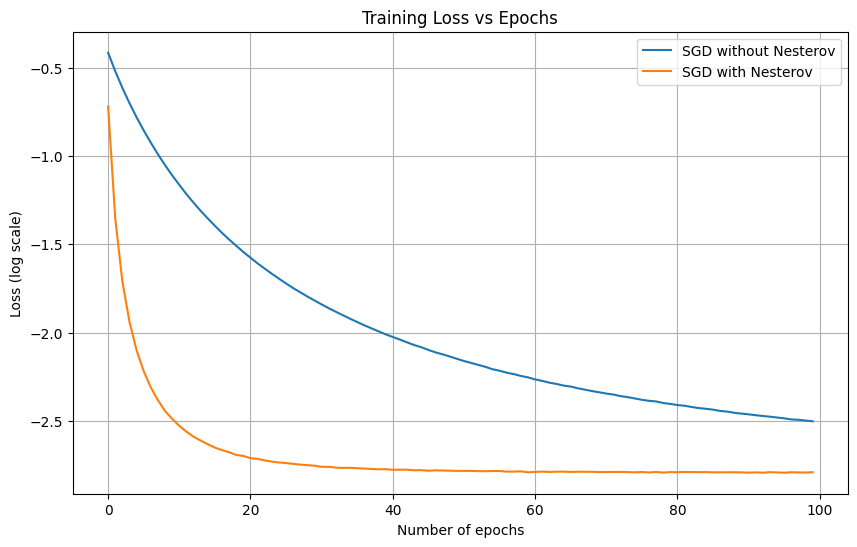

Final loss (SGD without Nesterov): 0.0820
Final loss (SGD with Nesterov): 0.0614


In [25]:
# Initialize params
w = w_init.copy()
w0 = w0_init
lambda_reg = 0.01
learning_rate = 1e-3
n_epochs = 100
batch_size = 128

# SGD without Nesterov
model_sgd = SGDLogisticRegression(w.copy(), w0, lambda_reg, batch_size, use_nesterov=False)
losses_sgd = train_sgd(X_train, y_train, model_sgd, learning_rate, n_epochs)

# SGD with Nesterov
model_sgd_nesterov = SGDLogisticRegression(w.copy(), w0, lambda_reg, batch_size, use_nesterov=True)
losses_sgd_nesterov = train_sgd(X_train, y_train, model_sgd_nesterov, learning_rate, n_epochs)

# Results
plt.figure(figsize=(10, 6))
updates = np.arange(len(losses_sgd))

plt.plot(updates, np.log(losses_sgd), label='SGD without Nesterov')
plt.plot(updates, np.log(losses_sgd_nesterov), label='SGD with Nesterov')
plt.xlabel('Number of epochs')
plt.ylabel('Loss (log scale)')
plt.title('Training Loss vs Epochs')
plt.grid(True)
plt.legend()
plt.show()

# Print final losses
print(f"Final loss (SGD without Nesterov): {losses_sgd[-1]:.4f}")
print(f"Final loss (SGD with Nesterov): {losses_sgd_nesterov[-1]:.4f}")

In [26]:
# Try different batch sizes
batch_sizes = [8, 64, 128]
for bs in batch_sizes:
    print(f"\nTraining with batch size {bs}")
    model_sgd = SGDLogisticRegression(w.copy(), w0, lambda_reg, bs, use_nesterov=False)
    losses = train_sgd(X_train, y_train, model_sgd, learning_rate, n_epochs)
    print(f"Final loss: {losses[-1]:.4f}")


Training with batch size 8


100%|██████████| 100/100 [00:08<00:00, 12.15it/s]


Final loss: 0.0613

Training with batch size 64


100%|██████████| 100/100 [00:09<00:00, 10.93it/s]


Final loss: 0.0671

Training with batch size 128


100%|██████████| 100/100 [00:05<00:00, 18.62it/s]

Final loss: 0.0820
